# Analysis and Process on ShanghaiTech Part A
https://www.kaggle.com/datasets/tthien/shanghaitech

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from scipy.io import loadmat

## Analysis Example Images

In [50]:
train_id = random.randint(1, 300)
test_id = random.randint(1, 182)

train_path = ".\\part_A\\train_data\\images\\IMG_{}.jpg".format(train_id)
test_path = ".\\part_A\\test_data\\images\\IMG_{}.jpg".format(test_id)


In [51]:
train_image = cv2.cvtColor(cv2.imread(train_path),cv2.COLOR_BGR2RGB)
test_image = cv2.cvtColor(cv2.imread(test_path),cv2.COLOR_BGR2RGB)

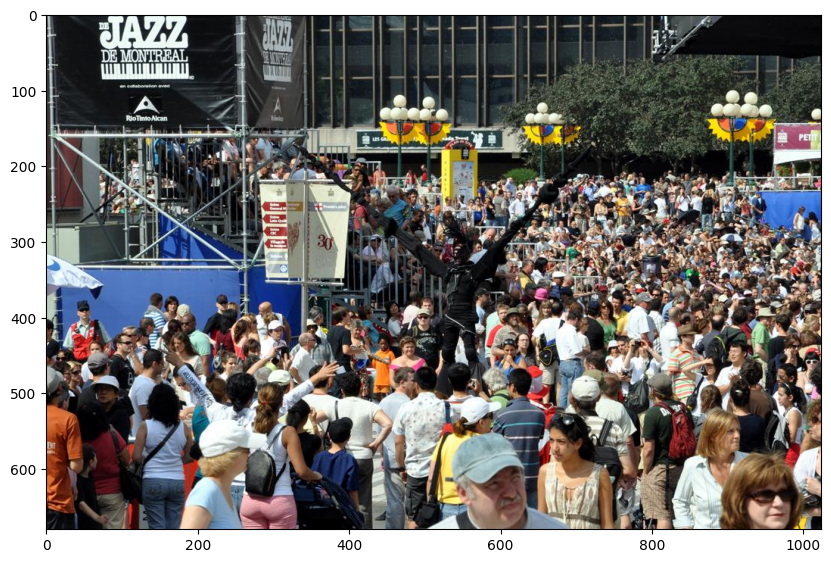

In [52]:
figure = plt.figure(figsize=(10,10))
plt.imshow(train_image)

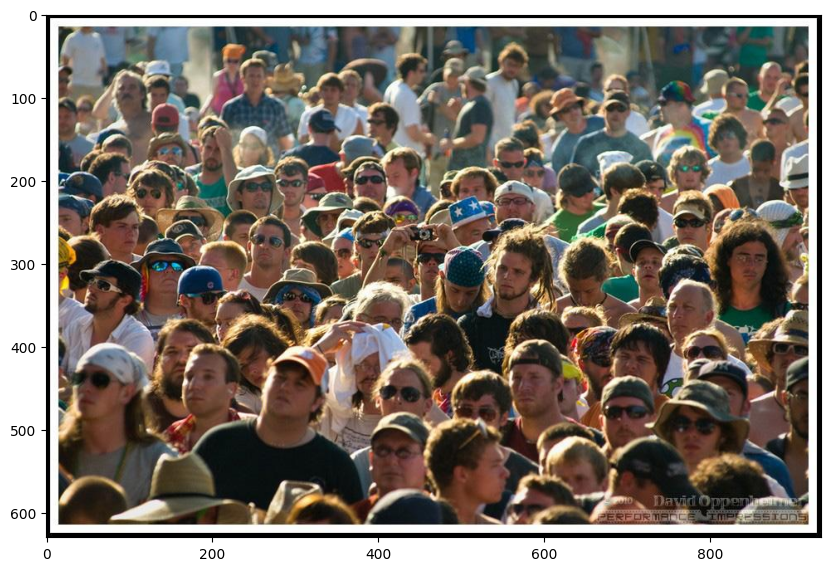

In [53]:
figure = plt.figure(figsize=(10,10))
plt.imshow(test_image)

## Analysis On Ground Truth

In [54]:
train_mat_path = "part_A\\train_data\\ground-truth\\GT_IMG_{}.mat".format(train_id)
test_mat_path = "part_A\\test_data\\ground-truth\\GT_IMG_{}.mat".format(test_id)

In [55]:
train_mat = loadmat(train_mat_path)
test_mat = loadmat(test_mat_path)

In [56]:
type(train_mat), type(test_mat)

(dict, dict)

In [57]:
train_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'image_info'])

In [58]:
train_mat['image_info']

array([[array([[(array([[   5.1658415 ,  498.26179794],
                       [  21.20788869,  503.19781246],
                       [  59.46200121,  532.81389958],
                       ...,
                       [1012.33767453,  265.96061464],
                       [1023.13520629,  295.26820085],
                       [ 293.42425042,  508.58905361]]), array([[554]], dtype=uint16))]],
              dtype=[('location', 'O'), ('number', 'O')])                                ]],
      dtype=object)

In [59]:
type(train_mat['image_info'])

numpy.ndarray

In [60]:
train_mat['image_info'].shape

(1, 1)

In [61]:
train_mat['image_info'][0][0][0][0][0].shape

(554, 2)

In [62]:
train_cord = train_mat['image_info'][0][0][0][0][0]
test_cord = test_mat['image_info'][0][0][0][0][0]

Text(0.5, 1.0, 'train')

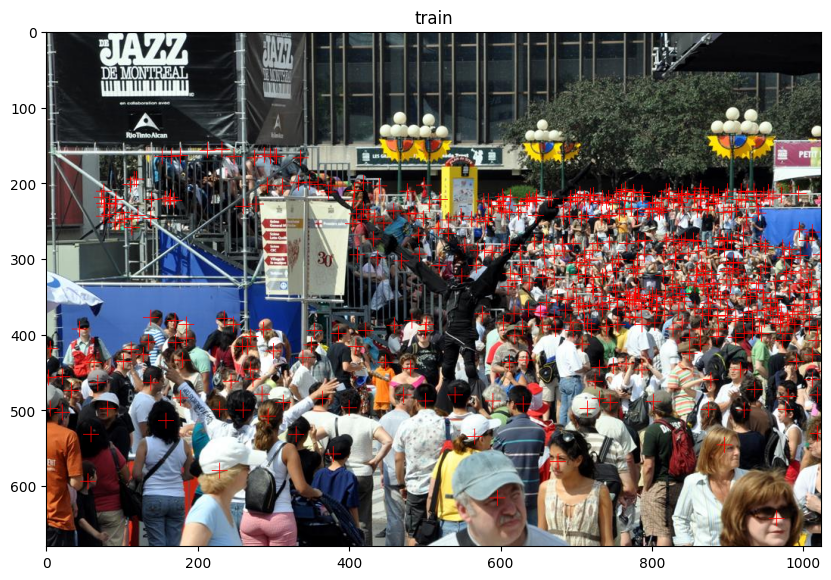

In [63]:
figure = plt.figure(figsize=(10,10))

for e_x_cor, e_y_cor in train_cord:
    e_x_cor = int(e_x_cor)
    e_y_cor = int(e_y_cor)
    cv2.drawMarker(train_image, (e_x_cor, e_y_cor), (255, 0, 0), thickness=1)

plt.imshow(train_image)
plt.title("train")

Text(0.5, 1.0, 'test')

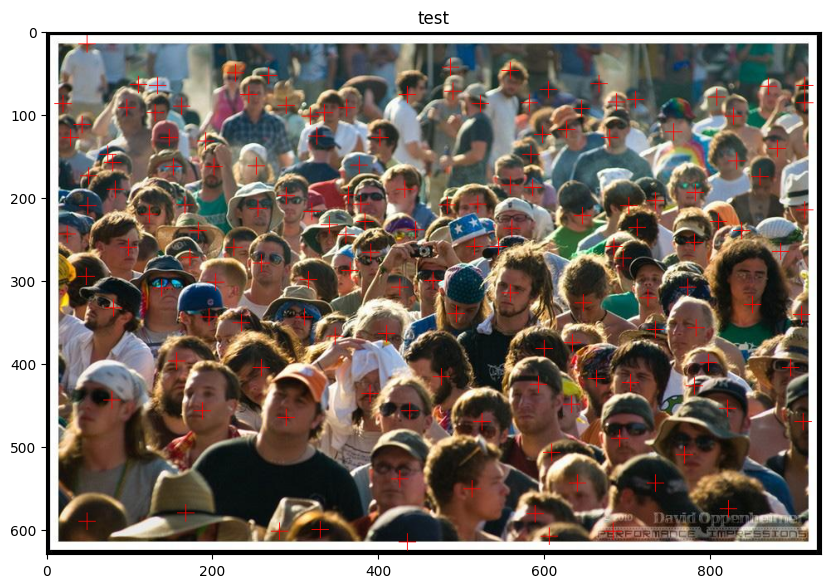

In [64]:
figure = plt.figure(figsize=(10,10))

for e_x_cor, e_y_cor in test_cord:
    e_x_cor = int(e_x_cor)
    e_y_cor = int(e_y_cor)
    cv2.drawMarker(test_image, (e_x_cor, e_y_cor), (255, 0, 0), thickness=1)

plt.imshow(test_image)
plt.title("test")

## Heatmap

In [86]:
def mark(img, cord):
    l = np.zeros(img.shape)
    
    for x, y in cord:
        x = int(x)
        y = int(y)
        l[y, x] = 1
    
    return l

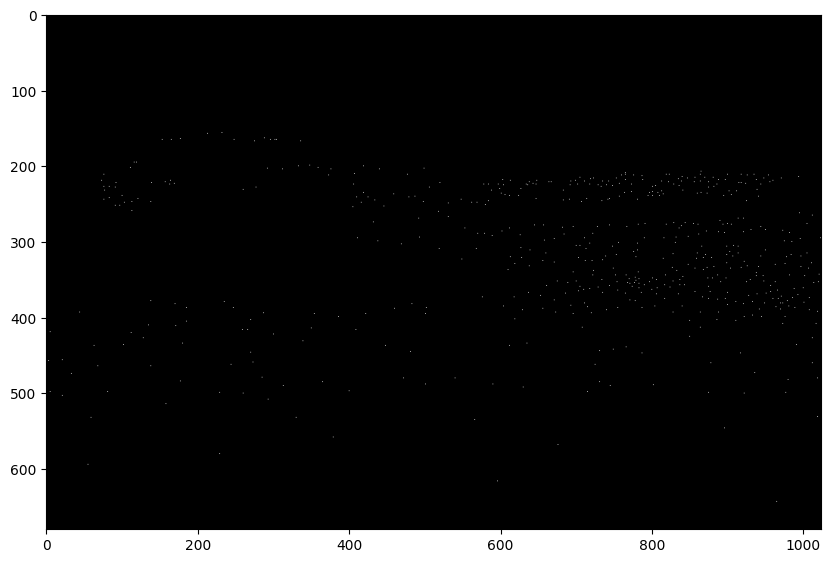

In [87]:
train_mark = mark(train_image, train_cord)
figure = plt.figure(figsize=(10, 10))
plt.imshow(train_mark, cmap='jet')

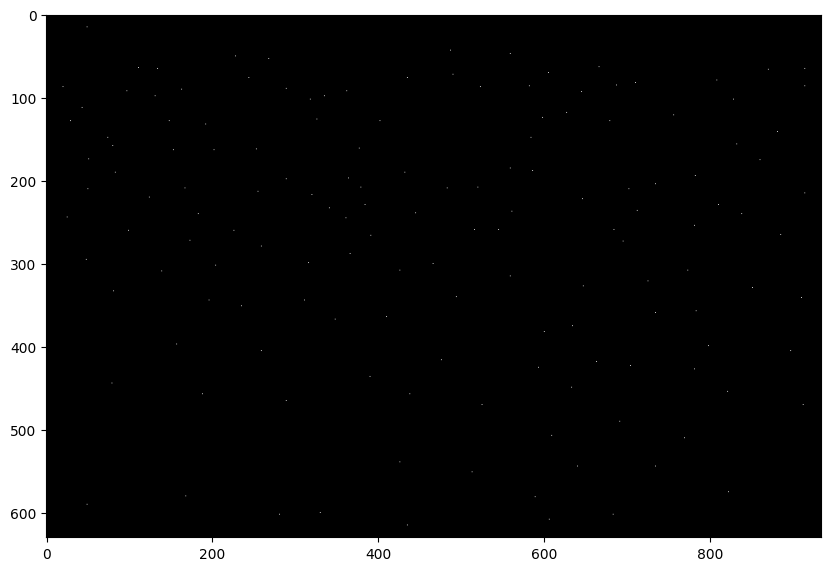

In [68]:
test_mark = mark(test_image, test_cord)
figure = plt.figure(figsize=(10, 10))
plt.imshow(test_mark, cmap='jet')

## Merge into Dataset

In [70]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os

In [139]:
# https://github.com/mlagunas/pytorch-nptransforms/blob/master/np_transforms.py

import numbers
import collections
from PIL import Image

def _is_numpy_image(img):
    return isinstance(img, np.ndarray)


def crop(pic, i, j, h, w):
    if not _is_numpy_image(pic):
        raise TypeError('img should be Numpy Image. Got {}'.format(type(pic)))

    return pic[i:i + h, j:j + w, :]


class RandomCrop(object):
    """
    Performs a random crop in a given numpy array using only the first two dimensions (width and height)
    """

    def __init__(self, size, ):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    @staticmethod
    def get_params(pic, output_size):

        # read dimensions (width, height, channels)
        w, h, c = pic.shape

        # read crop size
        th, tw = output_size

        # get crop indexes
        i = random.randint(0, w - tw)
        j = random.randint(0, h - th)

        return i, j, th, tw

    def __call__(self, pic):
        """
        :param input: numpy array
        :return: numpy array croped using self.size
        """

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        # if image has only 2 channels make it three channel
        if len(pic.shape) != 3:
            pic = pic.reshape(pic.shape[0], pic.shape[1], -1)

        # get crop params: starting pixels and size of the crop
        i, j, th, tw = self.get_params(pic, self.size)

        # perform cropping and return the new image
        return pic[i:i + th, j:j + tw, :]

class Normalize_01(object):
    """
    Normalize the values of a numpy array between 0-1
    """

    def __init__(self, min=None, max=None):
        """
        :param min: minimum value, by default None. Useful to normalize 0-1 globally
               max: maximum value, by default None. Useful to normalize 0-1 globally
        """
        self.min = min
        self.max = max

    def __call__(self, pic):
        """
        :param pic: numpy array
        :return: same array with its values normalized between 0-1
        """
        min = self.min if self.min is not None else np.min(pic)
        max = self.max if self.max is not None else np.max(pic)

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))
        pic = (pic - min) / (max - min)
        return pic
    
class ToTensor(object):
    """
    Convert a ``numpy.ndarray`` to tensor.
    """

    def __call__(self, pic):
        """
        Args:
            converts pic (numpy array) to Tensor
        Returns:
            Tensor: Converted image.
        """

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        if len(pic.shape) == 1: return torch.FloatTensor(pic.copy())

        return torch.FloatTensor(pic.transpose((2, 0, 1)).copy())
    
class Scale(object):
    """
    Rescale the given numpy image to a specified size.
    """

    def __init__(self, size, interpolation="bilinear"):
        assert isinstance(size, int) or (isinstance(size, collections.abc.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, pic):

        # check type of [pic]
        if not _is_numpy_image(pic):
            raise TypeError('img should be numpy array. Got {}'.format(type(pic)))

        if isinstance(self.size, int):
            # if size is specified with one dimension only get the second one keeping the
            # aspect-ratio

            # get the size of the original image
            w, h = pic.shape[:2]
            if (w <= h and w == self.size) or (h <= w and h == self.size):
                return pic

            # calculate the ouput size keeping the aspect-ratio
            if w < h:
                ow = self.size
                oh = int(self.size * h / w)
            else:
                oh = self.size
                ow = int(self.size * w / h)

            # create the output array
            img_out = np.zeros((ow, oh, pic.shape[2]))

            if len(pic.shape) == 3:
                # if 3D image, scale each channel individually
                for i in range(pic.shape[2]):
                    img_out[:, :, i] = np.array(Image.fromarray(pic[:, :, i]).resize((ow, oh)))
                return img_out
            else:
                # if 2D image, scale image
                return np.array(Image.fromarray(pic).resize((ow, oh)))
        else:
            # if size is specified with 2 dimensions apply the scale directly
            # create the output array

            if len(pic.shape) == 3:
                img_out = np.zeros((self.size[0], self.size[1], pic.shape[2]))

                # if 3D image, scale each channel individually
                for i in range(pic.shape[2]):
                    img_out[:, :, i] = np.array(Image.fromarray(pic[:, :, i]).resize(self.size))
                return img_out
            else:
                # if 2D image, scale image
                return np.array(Image.fromarray(pic).resize(self.size))
            
class Lambda(transforms.Lambda):
    pass


class Compose(transforms.Compose):
    pass


class Normalize(transforms.Normalize):
    pass


In [144]:
class PartADataset(Dataset):
    def __init__(self, img_dir, cord_dir, transform=None):
        self.img_dir = img_dir
        self.cord_dir = cord_dir
        self.transform = transform
        self.len = len(os.listdir(img_dir))
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, "IMG_{}.jpg".format(idx+1))
        cord_path = os.path.join(self.cord_dir, "GT_IMG_{}.mat".format(idx+1))
        
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        cord = loadmat(cord_path)['image_info'][0][0][0][0][0]
        cord = self.mark(img, cord)
        
        if self.transform:
            img = self.transform(img)
            cord = self.transform(cord)
                        
        sample = {'image': img, 'cord': cord}
        
        return sample
    
    def mark(self, img, cord):
        l = np.zeros(img.shape)
        
        for x, y in cord:
            x = int(x)
            y = int(y)
            l[y, x] = 1
        
        return l

## Test Dataset

In [96]:
train_dataset = PartADataset("part_A\\train_data\\images", "part_A\\train_data\\ground-truth")
test_dataset = PartADataset("part_A\\test_data\\images", "part_A\\test_data\\ground-truth")

(713, 1024, 3) (713, 1024, 3)


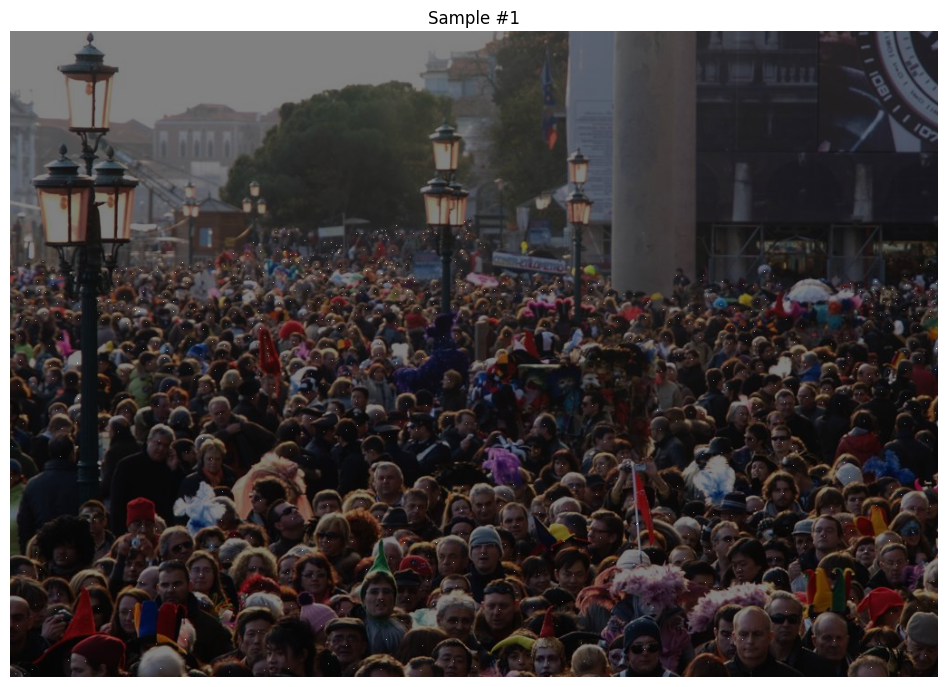

In [107]:
fig = plt.figure(figsize=(10, 10))

# for i in range(len(train_dataset)):
i = 1
sample = train_dataset[i]

print(sample['image'].shape, sample['cord'].shape)

ax = plt.subplot(1, 1, 1)
plt.tight_layout()
ax.set_title('Sample #{}'.format(i))
ax.axis('off')

plt.imshow(sample['image'])
plt.imshow(sample['cord'], alpha=0.5)
    
    # if i == 3: break
    

In [145]:
train_modified = PartADataset("part_A\\train_data\\images", "part_A\\train_data\\ground-truth", transform=transforms.Compose([
                                                                                                                              Scale(size=(512, 512)), 
                                                                                                                              RandomCrop((512, 512)),
                                                                                                                              Normalize_01(),
                                                                                                                              ToTensor()]))

torch.Size([3, 512, 512]) torch.Size([3, 512, 512])


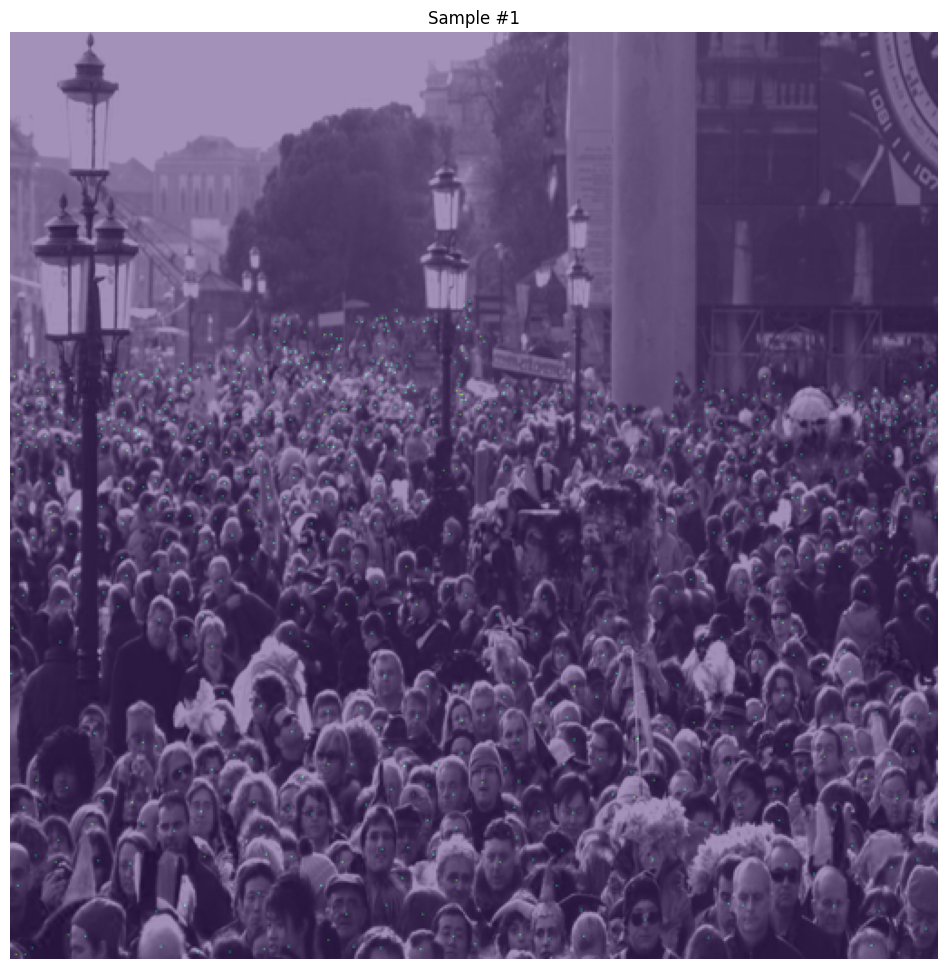

In [148]:
fig = plt.figure(figsize=(10, 10))

# for i in range(len(train_dataset)):
i = 1
sample = train_modified[i]

print(sample['image'].shape, sample['cord'].shape)

ax = plt.subplot(1, 1, 1)
plt.tight_layout()
ax.set_title('Sample #{}'.format(i))
ax.axis('off')

plt.imshow(sample['image'][0,:,:], cmap='gray')
plt.imshow(sample['cord'][0,:,:], alpha=0.5)
    
    # if i == 3: break
    